In [1]:
# default_exp optimization.quantum_annealing

In [2]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Quantum Annealing

> Quantum Annealing Optimization API

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
#export

import networkx as nx
import warnings

# dwave imports
import dwave_networkx as dnx
from dwave.system.composites import EmbeddingComposite
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler


# local imports
from quixotic.optimization.base import QuantumOptimizer, DEFAULT_LOCAL_SIMULATOR


SUPPORTED_TASKS = {'maximum_clique': dnx.maximum_clique,
                  'minimum_vertex_cover': dnx.min_vertex_cover,
                   'minimum_weighted_vertex_cover' :dnx.min_weighted_vertex_cover,
                   'maximum_independent_set': dnx.maximum_independent_set,
                   'maximum_weighted_independent_set' : dnx.maximum_weighted_independent_set,
                   'maximum_cut' : dnx.maximum_cut,
                   'weighted_maximum_cut' : dnx.weighted_maximum_cut,
                   'traveling_salesperson' : dnx.traveling_salesperson
                  }

class QuantumAnnealer:

    """quantum-based combinatorial optimization with Amazon Braket
    
    
    Usage:

    ```python
    >>> qo = QuantumAnnealer(g, 
                            task='maximum_clique', 
                            device_arn='device_arn', # optional
                            s3_folder='s3_folder')   # optional
        qo.execute()
        results = qo.results()
    ```
    
    **Parameters:**
    
    * **g** : a networkx Graph object
    * **task** : task as `str`.  Invoke `supported_tasks` static method to see options.
    * **device_arn** : Device ARN. Only required if not running locally.
    * **s3_folder** : S3 folder. Only required if not running locally.
    """
    def __init__(self, g, task=None,
                 device_arn=None, s3_folder=None,
                 ):
        """
        constructor
        """
        # error checks
        if task not in SUPPORTED_TASKS: raise ValueError(f'task {task} is not supported. ' +\
                                                         f'Supported tasks: {list(SUPPORTED_TASKS.keys())}')
        if not isinstance(g, nx.Graph): raise ValueError('g must be instance of networkx.Graph')
        if (device_arn is not None and s3_folder is None) or (device_arn is None and s3_folder is not None):
            raise ValueError('If one of device_arn or s3_folder is supplied, then both must be supplied.')
                        
        # input vars
        self.g = g
        self.task = task
        self.local = device_arn is None or s3_folder is None
        self.device_arn = device_arn
        self.s3_folder = s3_folder


        # computed vars
        self._last_result = None
        self._exec_called = False

    @staticmethod
    def supported_tasks():
        """
        Prints supported tasks (valid values for the `task` parameter).
        """
        for task in SUPPORTED_TASKS:
            print(task)
    
    def execute(self, verbose=1, **kwargs):
        """
        Approximate a solution to given task.
        Simulated Annealing is used when `QuantumAnnealer.local=True`.
        Quantum Annealing is used when `QuantumAnnealer.local=False`.
        """
        
        # setup sampler
        if self.local:
            if self.g.number_of_nodes() < 18:
                from dimod.reference.samplers import ExactSolver
                sampler = ExactSolver()
            else:
                import neal
                sampler = neal.SimulatedAnnealingSampler()
        else:
            braket_sampler = BraketSampler(self.s3_folder, self.device_arn)
            sampler = EmbeddingComposite(braket_sampler)
            if verbose: print('Executing on Amazon Braket with results stored in %s/%s.' % (self.s3_folder))

            
        # generate approximation
        kwargs = {}
        if 'weighted' in 'self.task': kwargs['weight'] = 'weight'
        apx_fn = SUPPORTED_TASKS[self.task]
        if self.local:
            result = apx_fn(self.g, sampler, **kwargs)
        else:
            kwargs['resultFormat'] = 'HISTOGRAM'
            #result = apx_fn(self.g, sampler, resultFormat="HISTOGRAM")      
            result = apx_fn(self.g, sampler, **kwargs)      


        self._last_result = result
        self._exec_called = True
        return self
                
    def results(self, **kwargs):
        """
        Return approximated solution
        """
        if not self._exec_called: raise Exception('The execute method must be called first.')
        if 'return_probs' in kwargs and kwargs['return_probs']:
            warnings.warn('return_probs not currently supported in QuantumAnnealer, '+\
                          'so returning None for second return value.')
            return self._last_result, None
        else:
            return self._last_result
    

    def plot_samples(self, probs):
        """
        Plot sample for toy problems for testing purposes.
        """
        raise NotImplemented('QuantumAnnealer does not currently support plot_samples.')


In [5]:
show_doc(QuantumAnnealer.execute)

<h4 id="QuantumAnnealer.execute" class="doc_header"><code>QuantumAnnealer.execute</code><a href="__main__.py#L82" class="source_link" style="float:right">[source]</a></h4>

> <code>QuantumAnnealer.execute</code>(**`verbose`**=*`1`*, **\*\*`kwargs`**)

Approximate a solution to given task.
Simulated Annealing is used when [`QuantumAnnealer.local=True`](/quixotic/optimization.quantum_annealing.html#QuantumAnnealer.local=True).
Quantum Annealing is used when [`QuantumAnnealer.local=False`](/quixotic/optimization.quantum_annealing.html#QuantumAnnealer.local=False).

In [6]:
show_doc(QuantumAnnealer.results)

<h4 id="QuantumAnnealer.results" class="doc_header"><code>QuantumAnnealer.results</code><a href="__main__.py#L119" class="source_link" style="float:right">[source]</a></h4>

> <code>QuantumAnnealer.results</code>(**\*\*`kwargs`**)

Return approximated solution

In [7]:
show_doc(QuantumAnnealer.supported_tasks)

<h4 id="QuantumAnnealer.supported_tasks" class="doc_header"><code>QuantumAnnealer.supported_tasks</code><a href="__main__.py#L74" class="source_link" style="float:right">[source]</a></h4>

> <code>QuantumAnnealer.supported_tasks</code>()

Prints supported tasks (valid values for the `task` parameter).

### Example: Minimum Vertex Cover with Quantum Annealing

The task is to find the nodes comprising the minimum vertex cover in a graph.  Let's construct a small star graph as input.

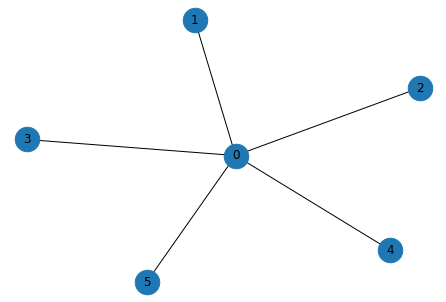

In [8]:
import networkx as nx

n = 6
g = nx.star_graph(n-1) 
seed = 1967
positions = nx.spring_layout(g, seed=seed)
nx.draw(g, with_labels=True, pos=positions, node_size=600)

In [9]:
qo = QuantumAnnealer(g, task='minimum_vertex_cover')

In [10]:
qo.execute()

In [11]:
nodes = qo.results()

In [12]:
nodes

[0]

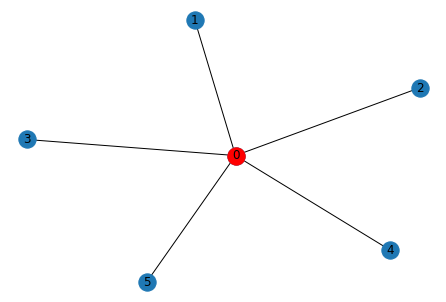

In [13]:
# plot solution as graph
sub = g.subgraph(nodes)
nx.draw(g, pos=positions, with_labels=True)
nx.draw(sub, pos=positions, node_color="r", edge_color="r")

In [14]:
assert set(nodes) == set([0])

In [15]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_optimization.base.ipynb.
Converted 02_optimization.quantum_annealing.ipynb.
Converted 03_optimization.qaoa.ipynb.
Converted 98_utils.ipynb.
Converted 99a_examples_quantum_annealing.ipynb.
Converted 99b_examples_qaoa.ipynb.
Converted index.ipynb.
